In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt -q

In [2]:
import pandas as pd
import numpy as np
from math import ceil

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Посмотрим на первые 5 строчек представленного датасета

In [3]:
df = pd.read_csv('predict.csv')
df.head()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,authors_mean_pagerank,authors_mean_productivity,journal_pagerank,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
0,16,1.0,-0.425436,500.0,1.0,1.0,6.0,NaN,NaN,NaN,101.0,66,1653,7,1.0,1.945910
1,8,7.0,-0.571967,134.0,1.0,1.0,6.0,NaN,NaN,NaN,24.0,59,1527,7,32.0,1.945910
2,15,19.0,-0.859644,235.0,1.0,1.0,5.0,NaN,NaN,NaN,49.0,169,1554,6,5.0,1.791759
3,6,4.0,-1.054999,1124.0,1.0,1.0,10.0,NaN,NaN,NaN,185.0,130,2121,11,7.0,2.397895
4,14,2.0,-0.476697,346.0,1.0,1.0,2.0,NaN,NaN,NaN,72.0,100,432,3,7.0,1.098612


Сразу же в глаза бросаются колонки с пустыми значениями *authors_mean_pagerank*, *authors_mean_productivity* и *journal_pagerank*. Рассмотрим сколько пропущенных данных есть в каждом столбце

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   recency                     479 non-null    int64  
 1   topic_rank                  479 non-null    float64
 2   diversity                   479 non-null    float64
 3   authors_mean_rank           473 non-null    float64
 4   authors_mean_hindex         473 non-null    float64
 5   authors_mean_gindex         473 non-null    float64
 6   authors_mean_sociality      473 non-null    float64
 7   authors_mean_pagerank       0 non-null      float64
 8   authors_mean_productivity   0 non-null      float64
 9   journal_pagerank            0 non-null      float64
 10  journal_rank                440 non-null    float64
 11  title_len                   479 non-null    int64  
 12  abstract_len                479 non-null    int64  
 13  n_authors                   479 non

Три столбца оказались не заполненными, удалим их, а затем посмотрим на процент пропущенных значений в оставшихся стобцах

In [5]:
df = df.dropna(how='all', axis=1)
df.head()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
0,16,1.0,-0.425436,500.0,1.0,1.0,6.0,101.0,66,1653,7,1.0,1.945910
1,8,7.0,-0.571967,134.0,1.0,1.0,6.0,24.0,59,1527,7,32.0,1.945910
2,15,19.0,-0.859644,235.0,1.0,1.0,5.0,49.0,169,1554,6,5.0,1.791759
3,6,4.0,-1.054999,1124.0,1.0,1.0,10.0,185.0,130,2121,11,7.0,2.397895
4,14,2.0,-0.476697,346.0,1.0,1.0,2.0,72.0,100,432,3,7.0,1.098612


In [6]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

recency - 0%
topic_rank - 0%
diversity - 0%
authors_mean_rank - 1%
authors_mean_hindex - 1%
authors_mean_gindex - 1%
authors_mean_sociality - 1%
journal_rank - 8%
title_len - 0%
abstract_len - 0%
n_authors - 0%
c5 - 0%
log_authors_mean_sociality - 1%


Всё выглядит достаточно безобидно, лишь столбец *journal_rank* имеет наибольшее количество пропущенных значений, по сравнению с другими.

Прежде чем находить объекты с большим количеством пропущенных значений, рассмотрим корреляцию признаков.

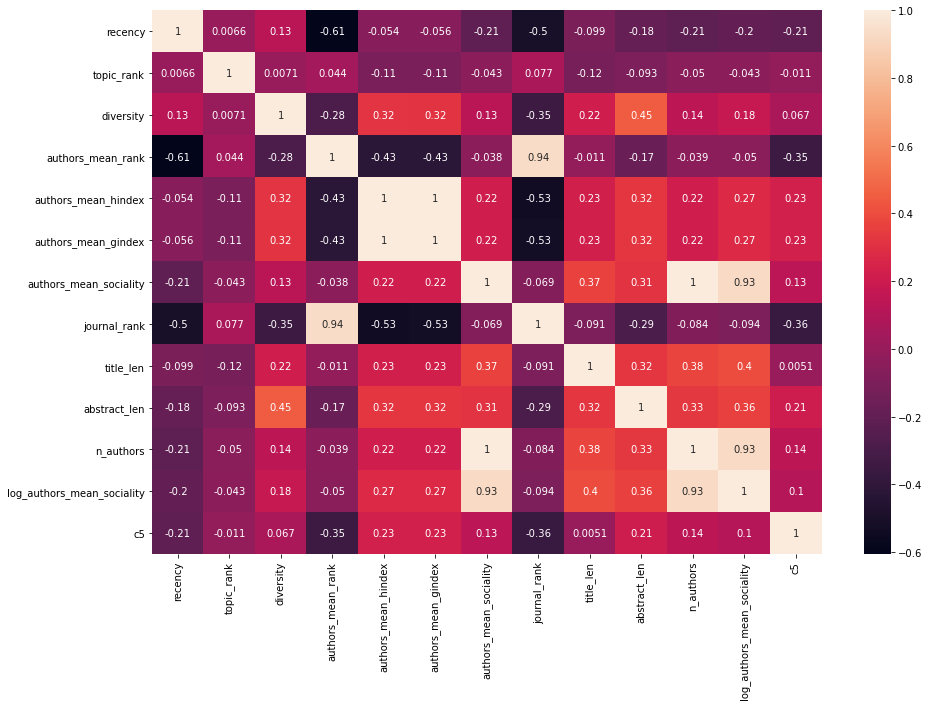

In [7]:
#Для удобства сделаем предсказываемый признак последним
df = df.reindex(columns=(
    list([elem for elem in df.columns if elem != 'c5'] + ['c5'])
))

plt.figure(figsize=(15,10))
hm = sns.heatmap(df.corr(),
                 cbar=True,
                 annot=True)

Имеется целый набор сильно коррелируемых признаков:
1. *n_authors*, *authors_mean_sociality*, *log_authors_mean_sociality*
2. *authors_mean_hindex*, *authors_mean_gindex*
3. *authors_mean_rank*, *journal_rank*

Из первого набора будет оставлен признак *n_authors*, так как он не имеет пропущенных значений.

Из второго оставим признак *authors_mean_hindex*.

Из третьего набора оставим *authors_mean_rank*, так как он имеет меньше пропущенных значений.

In [8]:
df = df.drop(['authors_mean_gindex', 'authors_mean_sociality', 'log_authors_mean_sociality',
              'journal_rank'], axis=1)

Теперь посмотрим, сколько объектов имеют пропущенные значения и в каком количестве

created missing indicator for: authors_mean_rank
created missing indicator for: authors_mean_hindex


<AxesSubplot:xlabel='index'>

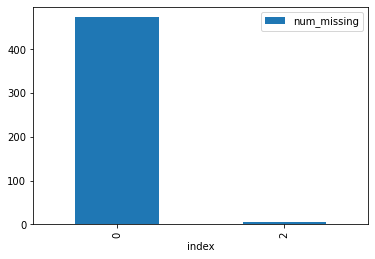

In [9]:
for col in df.columns:
    missing = df[col].isna()
    num_missing = np.sum(missing)
    if num_missing > 0:
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index() \
    .sort_values(by='index') \
    .plot.bar(x='index', y='num_missing')

Лишь несколько объектов имеют 2 пропущенных признака, заполним пропуски значением медианы признака.

In [10]:
cols_with_nan = df.columns[df.isna().any()].tolist()
for col in cols_with_nan:
    med = df[col].median()
    df[col] = df[col].fillna(med)
df = df[df.columns.drop(list(df.filter(regex='missing')))]

Посмотрим, есть ли стобцы, имеющие более 95% одинаковых значений.

In [11]:
num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Таким стобцов нет. Теперь с помощью диаграмм размаха для каждого признака найдём выбросы

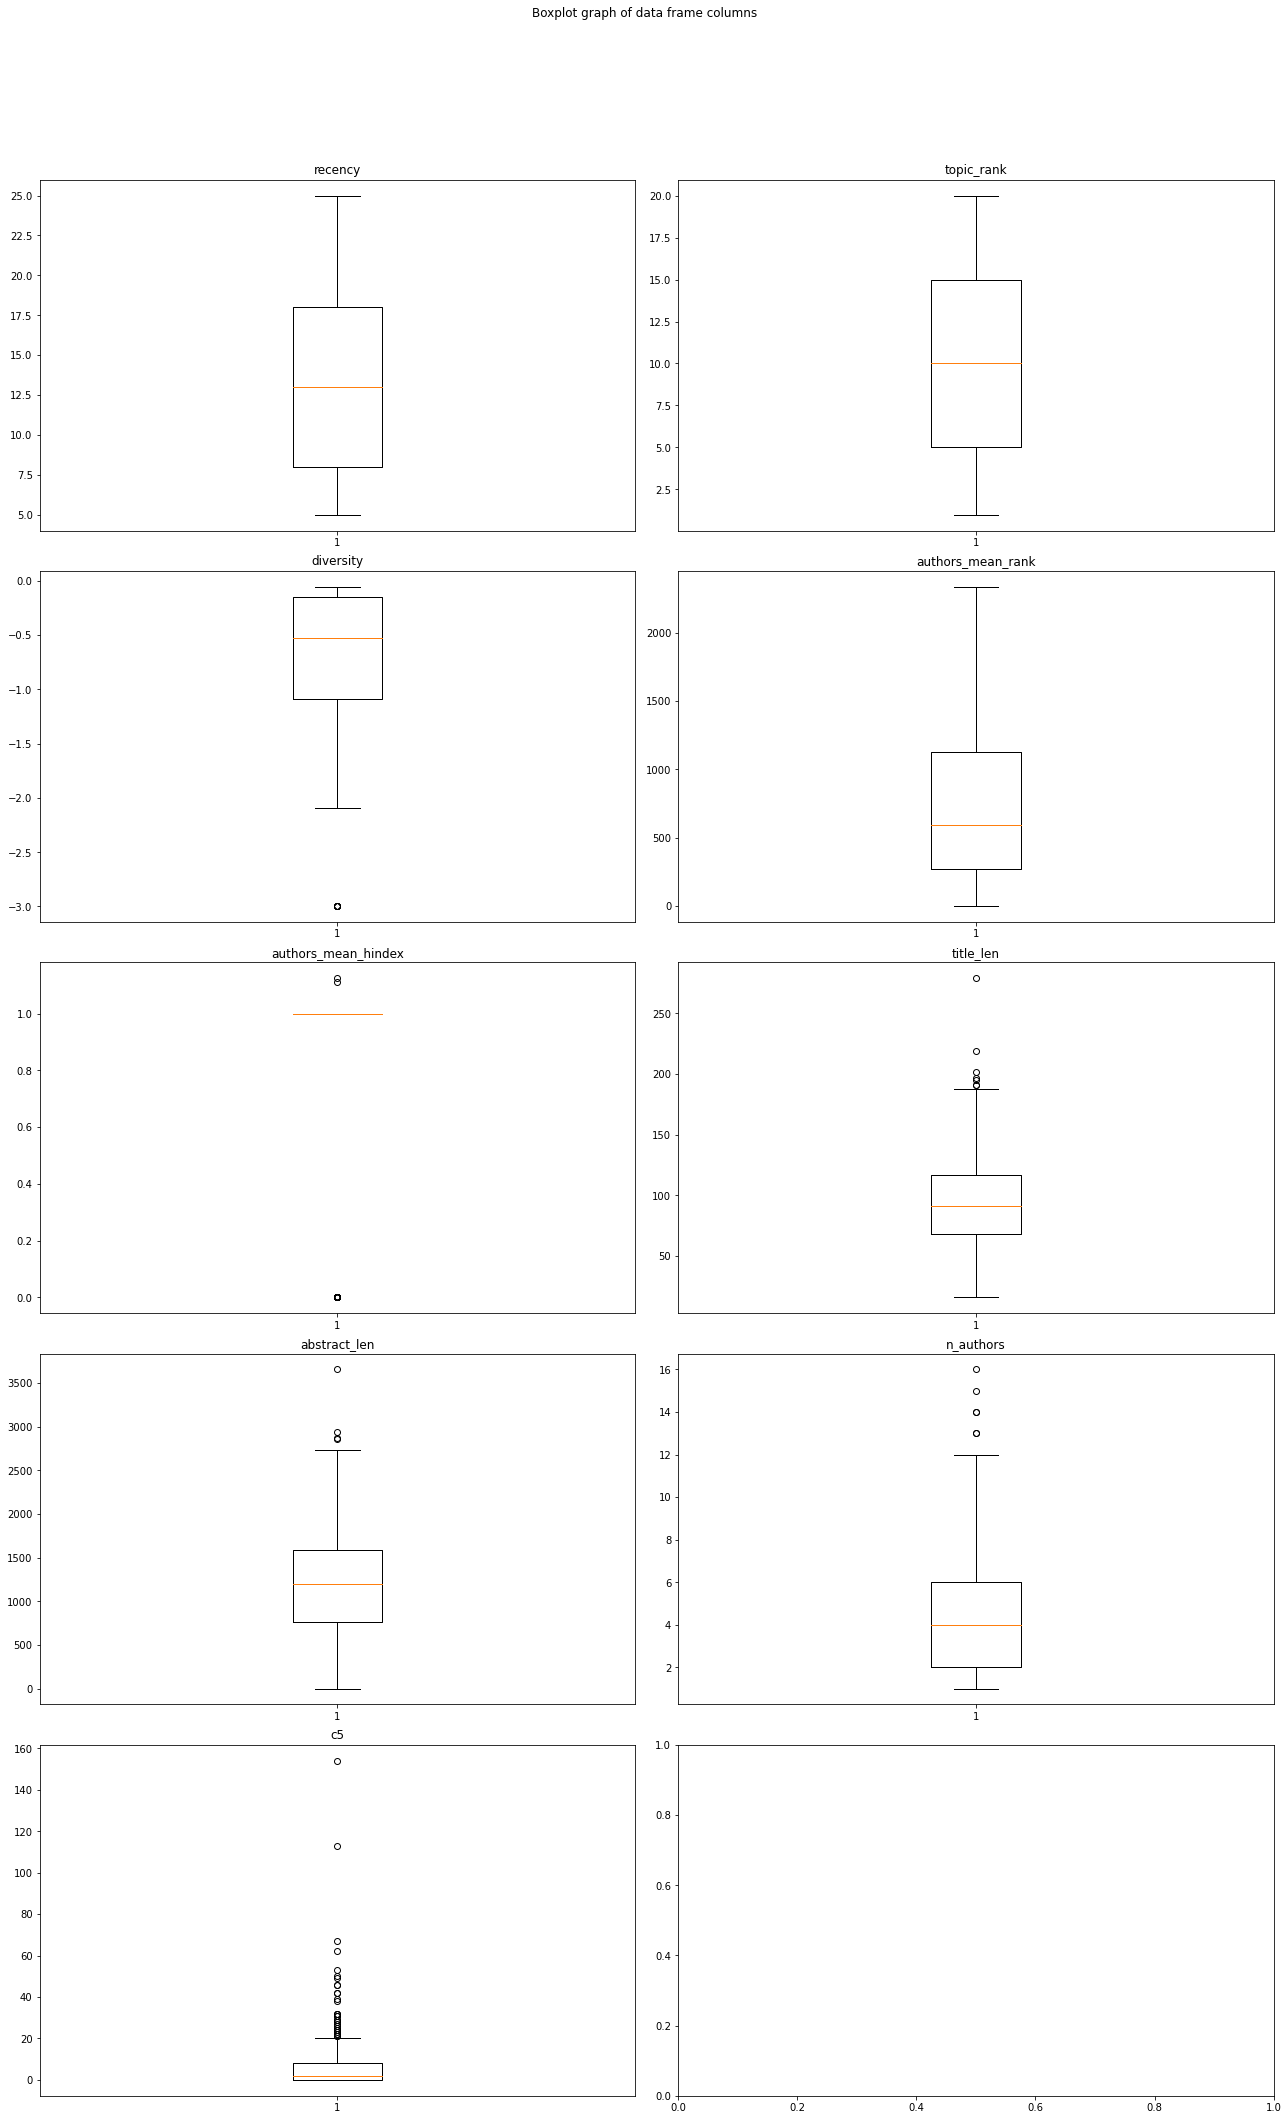

In [12]:
fig, axes = plt.subplots(ceil(len(df.columns.values) / 2), 2, figsize=(18, 30))
axes = np.delete(np.ravel(axes), -1)
for ax, col in zip(axes, df.columns.values):
    ax.boxplot(df[col])
    ax.set_title(col)
plt.suptitle('Boxplot graph of data frame columns')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Для более полной оценки рассмотрим описательную статистику.

In [13]:
df.describe()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,title_len,abstract_len,n_authors,c5
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,13.419624,10.125261,-0.675481,739.943691,0.846004,94.983299,1162.283925,4.369520,6.713987
std,5.860415,5.748655,0.606013,578.512669,0.362086,38.524238,657.597003,2.800775,12.547968
min,5.000000,1.000000,-2.995732,1.000000,0.000000,16.000000,0.000000,1.000000,0.000000
25%,8.000000,5.000000,-1.087146,268.000000,1.000000,68.000000,758.500000,2.000000,0.000000
50%,13.000000,10.000000,-0.526332,596.000000,1.000000,91.000000,1197.000000,4.000000,2.000000
75%,18.000000,15.000000,-0.150066,1129.000000,1.000000,116.500000,1587.500000,6.000000,8.000000
max,25.000000,20.000000,-0.056685,2336.000000,1.125000,279.000000,3655.000000,16.000000,154.000000


Выбросы присутствуют в следующих столбцах: *diversity*, *authors_mean_hindex*, *title_len*, *abstract_len*, *n_authors*, *c5*. Необходимо избавиться от выбросов и сделать это наиболее безболезненным способом. Основываясь на полученных данных, можно сделать следующие выводы:
1. Признак *diversity* ограничить снизу разностью первого квартиля и полутора межквартильных расстояний
2. Признак *authors_mean_hindex* ограничить сверху числом 1, так как подавляющее большинство данных имеют значения 0 и 1.
3. Признаки *title_len*, *abstract_len*, *n_authors*, *c5* ограничить сверху суммой третьего квартиля и полутора межквартильных расстояний

In [14]:
cols = ['diversity', 'title_len', 'abstract_len', 'n_authors', 'c5']
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

condition = (df['diversity'] > Q1['diversity'] - 1.5 * IQR['diversity']) & \
    (df['authors_mean_hindex'] <= 1) & \
    (df['title_len'] < Q3['title_len'] + 1.5 * IQR['title_len']) & \
    (df['abstract_len'] < Q3['abstract_len'] + 1.5 * IQR['abstract_len']) & \
    (df['n_authors'] < Q3['n_authors'] + 1.5 * IQR['n_authors']) & \
    (df['c5'] < Q3['c5'] + 1.5 * IQR['c5'])
    
df = df[condition].reset_index(drop=True)

Так как величина значений различных признаков существенна, стандартизируем их.

In [15]:
scaled_df = df.copy()
features = df.iloc[:, :-1]

scaler = StandardScaler()
scaled_df[features.columns.values] = scaler.fit_transform(features)

In [16]:
scaled_df

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,title_len,abstract_len,n_authors,c5
0,0.392327,-1.574329,0.417962,-0.490488,0.435662,-0.782912,0.839079,1.180740,1.0
1,0.221927,1.538099,-0.360909,-0.953793,0.435662,2.115572,0.680557,0.769196,5.0
2,-1.311680,-1.055591,-0.711333,0.600462,0.435662,1.018088,1.588459,2.826917,7.0
3,0.051526,-1.401416,0.326012,-0.759729,0.435662,0.173869,-1.116033,-0.465437,7.0
4,0.733129,-0.018115,-0.809960,-0.670565,0.435662,0.455275,-0.329825,1.180740,5.0
...,...,...,...,...,...,...,...,...,...
415,1.925934,-0.709765,0.587453,-0.441535,-2.295355,-0.895475,-0.774969,1.180740,0.0
416,-1.311680,0.327711,-1.497870,2.385495,-2.295355,-1.373865,-0.664483,-0.876981,0.0
417,1.755533,1.192274,-1.449151,-0.401324,-2.295355,-0.276381,-1.807768,0.357652,0.0
418,1.755533,-0.709765,-1.611339,-0.401324,-2.295355,-1.064319,-1.807768,-1.288525,0.0


Приступим к построению модели. Будем рассматривать 6 моделей:
* Линейную регрессию
* Логистическую регрессию
* Ридж регрессию
* Регрессию на основе k ближайших соседей
* Версию метода опорных векторов для регрессии
* Модель регрессии случайного леса
* Регрессию, основанную на градиентном бустинге

Изначально с подберём оптимальные параметры для каждой модели, за исключением линейной регресии (самая простая модель).

In [17]:
regressors = (
    LogisticRegression(),
    Ridge(),
    KNeighborsRegressor(),
    SVR(),
    RandomForestRegressor()
)
titles = (
    'Logistic regression',
    'Ridge regression',
    'K neighnours regression',
    'Epsilon-Support Vector Regression',
    'Random forest regression'
)

log_reg_params = {
    'tol': [1e-4, 1e-5],
    'C': [1e-3, 0.01, 0.1, 1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

ridge_params = {
    'alpha': [0.1, 1, 10, 100],
    'max_iter': [1000, 5000],
    'tol': [1e-3, 1e-4],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', \
               'sparse_cg', 'sag', 'saga'],
}

k_neighbors_params = {
    'n_neighbors': range(1, 22, 4),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(10, 101, 10),
    'p': [1, 2, 3]
}

svr_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'tol': [1e-3, 1e-4],
    'C': [1e-3, 0.01, 0.1, 1],
}

forest_params = {
    'n_estimators': [10, 25, 50, 75, 100],
    'criterion': ['mse', 'mae'],
    'max_depth': [5, 6, 7, 8],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

cat_params = {
    'num_trees': range(10, 51, 5),
    'learning_rate': [0.03, 0.1, 0.3, 0.5, 1],
    'depth': range(3, 11),
    'border_count': [20, 32, 50, 100, 200]
}
params_set = (
    log_reg_params,
    ridge_params,
    k_neighbors_params,
    svr_params,
    forest_params
)

X = scaled_df.iloc[:, :-1]
y = scaled_df.iloc[:, -1]

In [18]:
best_models = []
for regressor, title, params in zip(regressors, titles, params_set):
    grid = GridSearchCV(regressor, params, cv=5, n_jobs=-1)
    grid.fit(X, y)
    best_models.append(grid.best_estimator_)
    print('Best parameters for', title, 'are', grid.best_params_)

C:\Users\Mark\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best parameters for Logistic regression are {'C': 1, 'max_iter': 100, 'multi_class': 'auto', 'solver': 'liblinear', 'tol': 0.0001}
Best parameters for Ridge regression are {'alpha': 10, 'max_iter': 5000, 'solver': 'sag', 'tol': 0.0001}
Best parameters for K neighnours regression are {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best parameters for Epsilon-Support Vector Regression are {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}
Best parameters for Random forest regression are {'criterion': 'mse', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}


In [19]:
cat = CatBoostRegressor(thread_count=-1, loss_function='RMSE')
grid_search_result = cat.grid_search(cat_params, X, y, cv=5)


bestTest = 5.625269976
bestIteration = 9

0:	loss: 5.6252700	best: 5.6252700 (0)	total: 295ms	remaining: 8m 51s

bestTest = 4.579742757
bestIteration = 9

1:	loss: 4.5797428	best: 4.5797428 (1)	total: 303ms	remaining: 4m 32s

bestTest = 3.829206427
bestIteration = 9

2:	loss: 3.8292064	best: 3.8292064 (2)	total: 309ms	remaining: 3m 4s

bestTest = 3.526749061
bestIteration = 9

3:	loss: 3.5267491	best: 3.5267491 (3)	total: 314ms	remaining: 2m 21s

bestTest = 3.518532119
bestIteration = 5

4:	loss: 3.5185321	best: 3.5185321 (4)	total: 320ms	remaining: 1m 54s

bestTest = 5.2985924
bestIteration = 14

5:	loss: 5.2985924	best: 3.5185321 (4)	total: 327ms	remaining: 1m 37s

bestTest = 4.291525216
bestIteration = 14

6:	loss: 4.2915252	best: 3.5185321 (4)	total: 334ms	remaining: 1m 25s

bestTest = 3.697170971
bestIteration = 14

7:	loss: 3.6971710	best: 3.5185321 (4)	total: 341ms	remaining: 1m 16s

bestTest = 3.408709754
bestIteration = 14

8:	loss: 3.4087098	best: 3.4087098 (8)	total: 348ms	

bestTest = 3.302194792
bestIteration = 21

77:	loss: 3.3021948	best: 3.2003694 (59)	total: 1.42s	remaining: 31.3s

bestTest = 3.342234932
bestIteration = 17

78:	loss: 3.3422349	best: 3.2003694 (59)	total: 1.44s	remaining: 31.3s

bestTest = 3.20036936
bestIteration = 17

79:	loss: 3.2003694	best: 3.2003694 (59)	total: 1.46s	remaining: 31.3s

bestTest = 4.276364401
bestIteration = 44

80:	loss: 4.2763644	best: 3.2003694 (59)	total: 1.48s	remaining: 31.3s

bestTest = 3.37522961
bestIteration = 43

81:	loss: 3.3752296	best: 3.2003694 (59)	total: 1.5s	remaining: 31.4s

bestTest = 3.302194792
bestIteration = 21

82:	loss: 3.3021948	best: 3.2003694 (59)	total: 1.53s	remaining: 31.7s

bestTest = 3.342234932
bestIteration = 17

83:	loss: 3.3422349	best: 3.2003694 (59)	total: 1.56s	remaining: 31.8s

bestTest = 3.20036936
bestIteration = 17

84:	loss: 3.2003694	best: 3.2003694 (59)	total: 1.58s	remaining: 31.9s

bestTest = 4.172275815
bestIteration = 49

85:	loss: 4.1722758	best: 3.2003694 (59)	

bestTest = 3.73188475
bestIteration = 16

154:	loss: 3.7318847	best: 3.1203086 (152)	total: 2.75s	remaining: 29.2s

bestTest = 4.471803892
bestIteration = 29

155:	loss: 4.4718039	best: 3.1203086 (152)	total: 2.77s	remaining: 29.2s

bestTest = 3.484329625
bestIteration = 29

156:	loss: 3.4843296	best: 3.1203086 (152)	total: 2.79s	remaining: 29.2s

bestTest = 3.062157639
bestIteration = 28

157:	loss: 3.0621576	best: 3.0621576 (157)	total: 2.81s	remaining: 29.2s

bestTest = 3.489349974
bestIteration = 19

158:	loss: 3.4893500	best: 3.0621576 (157)	total: 2.83s	remaining: 29.2s

bestTest = 3.73188475
bestIteration = 16

159:	loss: 3.7318847	best: 3.0621576 (157)	total: 2.85s	remaining: 29.2s

bestTest = 4.298418904
bestIteration = 34

160:	loss: 4.2984189	best: 3.0621576 (157)	total: 2.88s	remaining: 29.3s

bestTest = 3.374141002
bestIteration = 33

161:	loss: 3.3741410	best: 3.0621576 (157)	total: 2.9s	remaining: 29.3s

bestTest = 3.062157639
bestIteration = 28

162:	loss: 3.0621576	bes

bestIteration = 14

231:	loss: 4.1560954	best: 3.0621576 (157)	total: 4.7s	remaining: 31.7s

bestTest = 3.12529806
bestIteration = 14

232:	loss: 3.1252981	best: 3.0621576 (157)	total: 4.71s	remaining: 31.7s

bestTest = 3.050631037
bestIteration = 14

233:	loss: 3.0506310	best: 3.0506310 (233)	total: 4.72s	remaining: 31.6s

bestTest = 3.584350737
bestIteration = 5

234:	loss: 3.5843507	best: 3.0506310 (233)	total: 4.74s	remaining: 31.6s

bestTest = 5.0091675
bestIteration = 19

235:	loss: 5.0091675	best: 3.0506310 (233)	total: 4.76s	remaining: 31.5s

bestTest = 3.844268404
bestIteration = 19

236:	loss: 3.8442684	best: 3.0506310 (233)	total: 4.78s	remaining: 31.5s

bestTest = 3.096063773
bestIteration = 15

237:	loss: 3.0960638	best: 3.0506310 (233)	total: 4.8s	remaining: 31.5s

bestTest = 3.014397596
bestIteration = 18

238:	loss: 3.0143976	best: 3.0143976 (238)	total: 4.82s	remaining: 31.5s

bestTest = 3.584350737
bestIteration = 5

239:	loss: 3.5843507	best: 3.0143976 (238)	total: 4


bestTest = 3.88800744
bestIteration = 24

304:	loss: 3.8880074	best: 2.8878347 (263)	total: 7.37s	remaining: 36.1s

bestTest = 4.249751776
bestIteration = 44

305:	loss: 4.2497518	best: 2.8878347 (263)	total: 7.45s	remaining: 36.4s

bestTest = 3.542377798
bestIteration = 44

306:	loss: 3.5423778	best: 2.8878347 (263)	total: 7.5s	remaining: 36.5s

bestTest = 3.048774895
bestIteration = 43

307:	loss: 3.0487749	best: 2.8878347 (263)	total: 7.55s	remaining: 36.6s

bestTest = 3.404492019
bestIteration = 20

308:	loss: 3.4044920	best: 2.8878347 (263)	total: 7.61s	remaining: 36.7s

bestTest = 3.88800744
bestIteration = 24

309:	loss: 3.8880074	best: 2.8878347 (263)	total: 7.67s	remaining: 36.9s

bestTest = 4.146490332
bestIteration = 49

310:	loss: 4.1464903	best: 2.8878347 (263)	total: 7.73s	remaining: 37s

bestTest = 3.532982953
bestIteration = 47

311:	loss: 3.5329830	best: 2.8878347 (263)	total: 7.79s	remaining: 37.1s

bestTest = 3.048774895
bestIteration = 43

312:	loss: 3.0487749	best

bestTest = 3.117756547
bestIteration = 25

382:	loss: 3.1177565	best: 2.8878347 (263)	total: 10.7s	remaining: 39.7s

bestTest = 3.419940306
bestIteration = 21

383:	loss: 3.4199403	best: 2.8878347 (263)	total: 10.7s	remaining: 39.6s

bestTest = 3.432670793
bestIteration = 17

384:	loss: 3.4326708	best: 2.8878347 (263)	total: 10.8s	remaining: 39.5s

bestTest = 4.48005792
bestIteration = 34

385:	loss: 4.4800579	best: 2.8878347 (263)	total: 10.8s	remaining: 39.4s

bestTest = 3.453799423
bestIteration = 34

386:	loss: 3.4537994	best: 2.8878347 (263)	total: 10.8s	remaining: 39.4s

bestTest = 3.084828326
bestIteration = 34

387:	loss: 3.0848283	best: 2.8878347 (263)	total: 10.8s	remaining: 39.3s

bestTest = 3.419940306
bestIteration = 21

388:	loss: 3.4199403	best: 2.8878347 (263)	total: 10.8s	remaining: 39.2s

bestTest = 3.432670793
bestIteration = 17

389:	loss: 3.4326708	best: 2.8878347 (263)	total: 10.8s	remaining: 39.1s

bestTest = 4.367602472
bestIteration = 39

390:	loss: 4.3676025	b

bestTest = 3.681160324
bestIteration = 9

453:	loss: 3.6811603	best: 2.8878347 (263)	total: 11.9s	remaining: 35.1s

bestTest = 3.633960692
bestIteration = 9

454:	loss: 3.6339607	best: 2.8878347 (263)	total: 11.9s	remaining: 35.1s

bestTest = 5.27799381
bestIteration = 14

455:	loss: 5.2779938	best: 2.8878347 (263)	total: 11.9s	remaining: 35s

bestTest = 3.95651864
bestIteration = 14

456:	loss: 3.9565186	best: 2.8878347 (263)	total: 11.9s	remaining: 34.9s

bestTest = 3.423588806
bestIteration = 14

457:	loss: 3.4235888	best: 2.8878347 (263)	total: 11.9s	remaining: 34.8s

bestTest = 3.588984626
bestIteration = 14

458:	loss: 3.5889846	best: 2.8878347 (263)	total: 11.9s	remaining: 34.8s

bestTest = 3.557567547
bestIteration = 13

459:	loss: 3.5575675	best: 2.8878347 (263)	total: 11.9s	remaining: 34.7s

bestTest = 4.998460057
bestIteration = 19

460:	loss: 4.9984601	best: 2.8878347 (263)	total: 11.9s	remaining: 34.6s

bestTest = 3.653504816
bestIteration = 18

461:	loss: 3.6535048	best: 


bestTest = 3.193556
bestIteration = 31

527:	loss: 3.1935560	best: 2.8878347 (263)	total: 13.2s	remaining: 31.7s

bestTest = 3.420858465
bestIteration = 27

528:	loss: 3.4208585	best: 2.8878347 (263)	total: 13.2s	remaining: 31.7s

bestTest = 3.631547385
bestIteration = 9

529:	loss: 3.6315474	best: 2.8878347 (263)	total: 13.2s	remaining: 31.7s

bestTest = 4.096328954
bestIteration = 44

530:	loss: 4.0963290	best: 2.8878347 (263)	total: 13.3s	remaining: 31.7s

bestTest = 3.229556719
bestIteration = 44

531:	loss: 3.2295567	best: 2.8878347 (263)	total: 13.3s	remaining: 31.7s

bestTest = 3.193556
bestIteration = 31

532:	loss: 3.1935560	best: 2.8878347 (263)	total: 13.3s	remaining: 31.7s

bestTest = 3.420858465
bestIteration = 27

533:	loss: 3.4208585	best: 2.8878347 (263)	total: 13.4s	remaining: 31.7s

bestTest = 3.631547385
bestIteration = 9

534:	loss: 3.6315474	best: 2.8878347 (263)	total: 13.4s	remaining: 31.6s

bestTest = 3.998819488
bestIteration = 49

535:	loss: 3.9988195	best: 2

601:	loss: 3.6724750	best: 2.8878347 (263)	total: 15.1s	remaining: 30s

bestTest = 3.202070205
bestIteration = 24

602:	loss: 3.2020702	best: 2.8878347 (263)	total: 15.1s	remaining: 30s

bestTest = 3.135125079
bestIteration = 11

603:	loss: 3.1351251	best: 2.8878347 (263)	total: 15.1s	remaining: 29.9s

bestTest = 3.79100353
bestIteration = 2

604:	loss: 3.7910035	best: 2.8878347 (263)	total: 15.1s	remaining: 29.9s

bestTest = 4.634269666
bestIteration = 29

605:	loss: 4.6342697	best: 2.8878347 (263)	total: 15.2s	remaining: 29.9s

bestTest = 3.516604799
bestIteration = 29

606:	loss: 3.5166048	best: 2.8878347 (263)	total: 15.2s	remaining: 29.9s

bestTest = 3.186927702
bestIteration = 28

607:	loss: 3.1869277	best: 2.8878347 (263)	total: 15.2s	remaining: 29.9s

bestTest = 3.135125079
bestIteration = 11

608:	loss: 3.1351251	best: 2.8878347 (263)	total: 15.3s	remaining: 29.9s

bestTest = 3.79100353
bestIteration = 2

609:	loss: 3.7910035	best: 2.8878347 (263)	total: 15.3s	remaining: 29.8s


bestTest = 3.316504482
bestIteration = 35

673:	loss: 3.3165045	best: 2.8878347 (263)	total: 18.1s	remaining: 30.2s

bestTest = 3.660278203
bestIteration = 12

674:	loss: 3.6602782	best: 2.8878347 (263)	total: 18.1s	remaining: 30.2s

bestTest = 5.724555788
bestIteration = 9

675:	loss: 5.7245558	best: 2.8878347 (263)	total: 18.2s	remaining: 30.2s

bestTest = 4.69205391
bestIteration = 9

676:	loss: 4.6920539	best: 2.8878347 (263)	total: 18.2s	remaining: 30.2s

bestTest = 3.886546627
bestIteration = 9

677:	loss: 3.8865466	best: 2.8878347 (263)	total: 18.2s	remaining: 30.1s

bestTest = 3.752562295
bestIteration = 9

678:	loss: 3.7525623	best: 2.8878347 (263)	total: 18.2s	remaining: 30.1s

bestTest = 4.039273191
bestIteration = 9

679:	loss: 4.0392732	best: 2.8878347 (263)	total: 18.3s	remaining: 30.1s

bestTest = 5.44335584
bestIteration = 14

680:	loss: 5.4433558	best: 2.8878347 (263)	total: 18.3s	remaining: 30.1s

bestTest = 4.246993996
bestIteration = 14

681:	loss: 4.2469940	best: 

bestTest = 3.201706506
bestIteration = 21

753:	loss: 3.2017065	best: 2.8878347 (263)	total: 21.8s	remaining: 30.2s

bestTest = 3.288021154
bestIteration = 24

754:	loss: 3.2880212	best: 2.8878347 (263)	total: 21.8s	remaining: 30.2s

bestTest = 4.250981215
bestIteration = 44

755:	loss: 4.2509812	best: 2.8878347 (263)	total: 21.8s	remaining: 30.1s

bestTest = 3.367034461
bestIteration = 44

756:	loss: 3.3670345	best: 2.8878347 (263)	total: 21.8s	remaining: 30.1s

bestTest = 3.229538556
bestIteration = 36

757:	loss: 3.2295386	best: 2.8878347 (263)	total: 21.9s	remaining: 30.1s

bestTest = 3.18116902
bestIteration = 44

758:	loss: 3.1811690	best: 2.8878347 (263)	total: 21.9s	remaining: 30s

bestTest = 3.288021154
bestIteration = 24

759:	loss: 3.2880212	best: 2.8878347 (263)	total: 21.9s	remaining: 30s

bestTest = 4.168379092
bestIteration = 49

760:	loss: 4.1683791	best: 2.8878347 (263)	total: 21.9s	remaining: 30s

bestTest = 3.357944558
bestIteration = 49

761:	loss: 3.3579446	best: 2

bestIteration = 24

826:	loss: 3.6862791	best: 2.8878347 (263)	total: 23.1s	remaining: 27.2s

bestTest = 3.171588007
bestIteration = 24

827:	loss: 3.1715880	best: 2.8878347 (263)	total: 23.2s	remaining: 27.2s

bestTest = 3.270416883
bestIteration = 21

828:	loss: 3.2704169	best: 2.8878347 (263)	total: 23.2s	remaining: 27.1s

bestTest = 3.429476258
bestIteration = 4

829:	loss: 3.4294763	best: 2.8878347 (263)	total: 23.2s	remaining: 27.1s

bestTest = 4.565177737
bestIteration = 29

830:	loss: 4.5651777	best: 2.8878347 (263)	total: 23.2s	remaining: 27.1s

bestTest = 3.614045774
bestIteration = 29

831:	loss: 3.6140458	best: 2.8878347 (263)	total: 23.2s	remaining: 27s

bestTest = 3.128671443
bestIteration = 29

832:	loss: 3.1286714	best: 2.8878347 (263)	total: 23.3s	remaining: 27s

bestTest = 3.270416883
bestIteration = 21

833:	loss: 3.2704169	best: 2.8878347 (263)	total: 23.3s	remaining: 27s

bestTest = 3.429476258
bestIteration = 4

834:	loss: 3.4294763	best: 2.8878347 (263)	total: 23

901:	loss: 4.5359395	best: 2.8878347 (263)	total: 25.1s	remaining: 25s

bestTest = 3.717660482
bestIteration = 9

902:	loss: 3.7176605	best: 2.8878347 (263)	total: 25.1s	remaining: 24.9s

bestTest = 3.411100187
bestIteration = 8

903:	loss: 3.4111002	best: 2.8878347 (263)	total: 25.1s	remaining: 24.9s

bestTest = 3.478991462
bestIteration = 5

904:	loss: 3.4789915	best: 2.8878347 (263)	total: 25.1s	remaining: 24.8s

bestTest = 5.223342609
bestIteration = 14

905:	loss: 5.2233426	best: 2.8878347 (263)	total: 25.2s	remaining: 24.8s

bestTest = 4.126899324
bestIteration = 14

906:	loss: 4.1268993	best: 2.8878347 (263)	total: 25.2s	remaining: 24.8s

bestTest = 3.451728571
bestIteration = 14

907:	loss: 3.4517286	best: 2.8878347 (263)	total: 25.2s	remaining: 24.7s

bestTest = 3.37111276
bestIteration = 14

908:	loss: 3.3711128	best: 2.8878347 (263)	total: 25.2s	remaining: 24.7s

bestTest = 3.432251482
bestIteration = 12

909:	loss: 3.4322515	best: 2.8878347 (263)	total: 25.2s	remaining: 24.

bestTest = 4.247345756
bestIteration = 39

975:	loss: 4.2473458	best: 2.8878347 (263)	total: 27.6s	remaining: 23.3s

bestTest = 3.28293002
bestIteration = 39

976:	loss: 3.2829300	best: 2.8878347 (263)	total: 27.7s	remaining: 23.3s

bestTest = 3.091945
bestIteration = 31

977:	loss: 3.0919450	best: 2.8878347 (263)	total: 27.7s	remaining: 23.3s

bestTest = 3.063388431
bestIteration = 39

978:	loss: 3.0633884	best: 2.8878347 (263)	total: 27.8s	remaining: 23.3s

bestTest = 3.783988687
bestIteration = 18

979:	loss: 3.7839887	best: 2.8878347 (263)	total: 27.9s	remaining: 23.3s

bestTest = 4.111539499
bestIteration = 44

980:	loss: 4.1115395	best: 2.8878347 (263)	total: 28s	remaining: 23.4s

bestTest = 3.188681447
bestIteration = 44

981:	loss: 3.1886814	best: 2.8878347 (263)	total: 28.1s	remaining: 23.4s

bestTest = 3.091945
bestIteration = 31

982:	loss: 3.0919450	best: 2.8878347 (263)	total: 28.2s	remaining: 23.4s

bestTest = 3.063388431
bestIteration = 39

983:	loss: 3.0633884	best: 2.8


bestTest = 3.377094895
bestIteration = 18

1048:	loss: 3.3770949	best: 2.8878347 (263)	total: 32.1s	remaining: 23s

bestTest = 4.117368443
bestIteration = 16

1049:	loss: 4.1173684	best: 2.8878347 (263)	total: 32.2s	remaining: 23s

bestTest = 4.980242584
bestIteration = 24

1050:	loss: 4.9802426	best: 2.8878347 (263)	total: 32.3s	remaining: 23s

bestTest = 3.701264349
bestIteration = 24

1051:	loss: 3.7012643	best: 2.8878347 (263)	total: 32.3s	remaining: 23s

bestTest = 3.36602048
bestIteration = 23

1052:	loss: 3.3660205	best: 2.8878347 (263)	total: 32.4s	remaining: 23s

bestTest = 3.356579796
bestIteration = 22

1053:	loss: 3.3565798	best: 2.8878347 (263)	total: 32.5s	remaining: 23s

bestTest = 4.117368443
bestIteration = 16

1054:	loss: 4.1173684	best: 2.8878347 (263)	total: 32.6s	remaining: 23s

bestTest = 4.746469874
bestIteration = 29

1055:	loss: 4.7464699	best: 2.8878347 (263)	total: 32.7s	remaining: 23s

bestTest = 3.560458682
bestIteration = 29

1056:	loss: 3.5604587	best: 2


bestTest = 3.195546757
bestIteration = 36

1118:	loss: 3.1955468	best: 2.8878347 (263)	total: 36.7s	remaining: 22.3s

bestTest = 3.30610922
bestIteration = 23

1119:	loss: 3.3061092	best: 2.8878347 (263)	total: 36.7s	remaining: 22.3s

bestTest = 4.122929444
bestIteration = 49

1120:	loss: 4.1229294	best: 2.8878347 (263)	total: 36.7s	remaining: 22.2s

bestTest = 3.324654134
bestIteration = 49

1121:	loss: 3.3246541	best: 2.8878347 (263)	total: 36.8s	remaining: 22.2s

bestTest = 3.301047207
bestIteration = 34

1122:	loss: 3.3010472	best: 2.8878347 (263)	total: 36.8s	remaining: 22.2s

bestTest = 3.195546757
bestIteration = 36

1123:	loss: 3.1955468	best: 2.8878347 (263)	total: 36.8s	remaining: 22.1s

bestTest = 3.30610922
bestIteration = 23

1124:	loss: 3.3061092	best: 2.8878347 (263)	total: 36.8s	remaining: 22.1s

bestTest = 5.509589061
bestIteration = 9

1125:	loss: 5.5095891	best: 2.8878347 (263)	total: 36.8s	remaining: 22s

bestTest = 4.350822922
bestIteration = 9

1126:	loss: 4.3508


bestTest = 4.397402067
bestIteration = 34

1195:	loss: 4.3974021	best: 2.8878347 (263)	total: 38s	remaining: 19.2s

bestTest = 3.393540208
bestIteration = 34

1196:	loss: 3.3935402	best: 2.8878347 (263)	total: 38s	remaining: 19.2s

bestTest = 3.256416244
bestIteration = 33

1197:	loss: 3.2564162	best: 2.8878347 (263)	total: 38.1s	remaining: 19.1s

bestTest = 3.35062643
bestIteration = 31

1198:	loss: 3.3506264	best: 2.8878347 (263)	total: 38.1s	remaining: 19.1s

bestTest = 3.653515702
bestIteration = 25

1199:	loss: 3.6535157	best: 2.8878347 (263)	total: 38.1s	remaining: 19.1s

bestTest = 4.233237302
bestIteration = 39

1200:	loss: 4.2332373	best: 2.8878347 (263)	total: 38.1s	remaining: 19s

bestTest = 3.311624548
bestIteration = 39

1201:	loss: 3.3116245	best: 2.8878347 (263)	total: 38.2s	remaining: 19s

bestTest = 3.221260278
bestIteration = 39

1202:	loss: 3.2212603	best: 2.8878347 (263)	total: 38.2s	remaining: 19s

bestTest = 3.35062643
bestIteration = 31

1203:	loss: 3.3506264	be

bestTest = 3.215088672
bestIteration = 12

1268:	loss: 3.2150887	best: 2.8878347 (263)	total: 40.2s	remaining: 16.8s

bestTest = 3.82832426
bestIteration = 3

1269:	loss: 3.8283243	best: 2.8878347 (263)	total: 40.2s	remaining: 16.8s

bestTest = 4.944360431
bestIteration = 19

1270:	loss: 4.9443604	best: 2.8878347 (263)	total: 40.2s	remaining: 16.8s

bestTest = 3.754279057
bestIteration = 19

1271:	loss: 3.7542791	best: 2.8878347 (263)	total: 40.3s	remaining: 16.7s

bestTest = 3.218045801
bestIteration = 19

1272:	loss: 3.2180458	best: 2.8878347 (263)	total: 40.3s	remaining: 16.7s

bestTest = 3.185531056
bestIteration = 19

1273:	loss: 3.1855311	best: 2.8878347 (263)	total: 40.3s	remaining: 16.6s

bestTest = 3.82832426
bestIteration = 3

1274:	loss: 3.8283243	best: 2.8878347 (263)	total: 40.4s	remaining: 16.6s

bestTest = 4.679270897
bestIteration = 24

1275:	loss: 4.6792709	best: 2.8878347 (263)	total: 40.4s	remaining: 16.6s

bestTest = 3.56561195
bestIteration = 24

1276:	loss: 3.5656


bestTest = 4.072167153
bestIteration = 44

1340:	loss: 4.0721672	best: 2.8878347 (263)	total: 43.5s	remaining: 14.9s

bestTest = 3.257961237
bestIteration = 44

1341:	loss: 3.2579612	best: 2.8878347 (263)	total: 43.5s	remaining: 14.9s

bestTest = 3.221589935
bestIteration = 21

1342:	loss: 3.2215899	best: 2.8878347 (263)	total: 43.6s	remaining: 14.8s

bestTest = 3.13925275
bestIteration = 16

1343:	loss: 3.1392527	best: 2.8878347 (263)	total: 43.7s	remaining: 14.8s

bestTest = 3.643623153
bestIteration = 8

1344:	loss: 3.6436232	best: 2.8878347 (263)	total: 43.8s	remaining: 14.8s

bestTest = 3.966636211
bestIteration = 49

1345:	loss: 3.9666362	best: 2.8878347 (263)	total: 43.9s	remaining: 14.8s

bestTest = 3.244601964
bestIteration = 49

1346:	loss: 3.2446020	best: 2.8878347 (263)	total: 43.9s	remaining: 14.8s

bestTest = 3.220074903
bestIteration = 48

1347:	loss: 3.2200749	best: 2.8878347 (263)	total: 44s	remaining: 14.8s

bestTest = 3.13925275
bestIteration = 16

1348:	loss: 3.139


bestTest = 3.460137845
bestIteration = 22

1412:	loss: 3.4601378	best: 2.8878347 (263)	total: 49.8s	remaining: 13.6s

bestTest = 3.683998295
bestIteration = 22

1413:	loss: 3.6839983	best: 2.8878347 (263)	total: 50s	remaining: 13.6s

bestTest = 4.414156994
bestIteration = 20

1414:	loss: 4.4141570	best: 2.8878347 (263)	total: 50.1s	remaining: 13.6s

bestTest = 4.677929222
bestIteration = 29

1415:	loss: 4.6779292	best: 2.8878347 (263)	total: 50.3s	remaining: 13.6s

bestTest = 3.538758365
bestIteration = 29

1416:	loss: 3.5387584	best: 2.8878347 (263)	total: 50.4s	remaining: 13.6s

bestTest = 3.422887456
bestIteration = 29

1417:	loss: 3.4228875	best: 2.8878347 (263)	total: 50.6s	remaining: 13.6s

bestTest = 3.683998295
bestIteration = 22

1418:	loss: 3.6839983	best: 2.8878347 (263)	total: 50.8s	remaining: 13.6s

bestTest = 4.414156994
bestIteration = 20

1419:	loss: 4.4141570	best: 2.8878347 (263)	total: 51s	remaining: 13.6s

bestTest = 4.520815545
bestIteration = 34

1420:	loss: 4.52


bestTest = 3.060743634
bestIteration = 25

1483:	loss: 3.0607436	best: 2.8878347 (263)	total: 57s	remaining: 12.1s

bestTest = 3.508274546
bestIteration = 6

1484:	loss: 3.5082745	best: 2.8878347 (263)	total: 57s	remaining: 12.1s

bestTest = 5.601640226
bestIteration = 9

1485:	loss: 5.6016402	best: 2.8878347 (263)	total: 57s	remaining: 12s

bestTest = 4.357969276
bestIteration = 9

1486:	loss: 4.3579693	best: 2.8878347 (263)	total: 57s	remaining: 12s

bestTest = 3.821344168
bestIteration = 9

1487:	loss: 3.8213442	best: 2.8878347 (263)	total: 57s	remaining: 12s

bestTest = 3.810504662
bestIteration = 9

1488:	loss: 3.8105047	best: 2.8878347 (263)	total: 57s	remaining: 11.9s

bestTest = 4.060123564
bestIteration = 9

1489:	loss: 4.0601236	best: 2.8878347 (263)	total: 57s	remaining: 11.9s

bestTest = 5.286623468
bestIteration = 14

1490:	loss: 5.2866235	best: 2.8878347 (263)	total: 57s	remaining: 11.8s

bestTest = 3.984299025
bestIteration = 14

1491:	loss: 3.9842990	best: 2.8878347 (2

bestTest = 3.254427501
bestIteration = 31

1558:	loss: 3.2544275	best: 2.8878347 (263)	total: 58.5s	remaining: 9.05s

bestTest = 4.082707373
bestIteration = 10

1559:	loss: 4.0827074	best: 2.8878347 (263)	total: 58.6s	remaining: 9.01s

bestTest = 4.255366344
bestIteration = 39

1560:	loss: 4.2553663	best: 2.8878347 (263)	total: 58.6s	remaining: 8.97s

bestTest = 3.360034182
bestIteration = 39

1561:	loss: 3.3600342	best: 2.8878347 (263)	total: 58.6s	remaining: 8.94s

bestTest = 3.054527014
bestIteration = 39

1562:	loss: 3.0545270	best: 2.8878347 (263)	total: 58.7s	remaining: 8.9s

bestTest = 3.254427501
bestIteration = 31

1563:	loss: 3.2544275	best: 2.8878347 (263)	total: 58.7s	remaining: 8.86s

bestTest = 4.082707373
bestIteration = 10

1564:	loss: 4.0827074	best: 2.8878347 (263)	total: 58.7s	remaining: 8.82s

bestTest = 4.128724822
bestIteration = 44

1565:	loss: 4.1287248	best: 2.8878347 (263)	total: 58.8s	remaining: 8.78s

bestTest = 3.313957735
bestIteration = 43

1566:	loss: 3.


bestTest = 3.253527896
bestIteration = 19

1633:	loss: 3.2535279	best: 2.8878347 (263)	total: 1m 1s	remaining: 6.24s

bestTest = 3.410736202
bestIteration = 9

1634:	loss: 3.4107362	best: 2.8878347 (263)	total: 1m 1s	remaining: 6.2s

bestTest = 4.682830577
bestIteration = 24

1635:	loss: 4.6828306	best: 2.8878347 (263)	total: 1m 1s	remaining: 6.16s

bestTest = 3.470800046
bestIteration = 24

1636:	loss: 3.4708000	best: 2.8878347 (263)	total: 1m 1s	remaining: 6.12s

bestTest = 3.087110124
bestIteration = 23

1637:	loss: 3.0871101	best: 2.8878347 (263)	total: 1m 1s	remaining: 6.09s

bestTest = 3.223851949
bestIteration = 22

1638:	loss: 3.2238519	best: 2.8878347 (263)	total: 1m 1s	remaining: 6.05s

bestTest = 3.410736202
bestIteration = 9

1639:	loss: 3.4107362	best: 2.8878347 (263)	total: 1m 1s	remaining: 6.01s

bestTest = 4.506002939
bestIteration = 29

1640:	loss: 4.5060029	best: 2.8878347 (263)	total: 1m 1s	remaining: 5.98s

bestTest = 3.336136187
bestIteration = 29

1641:	loss: 3.3


bestTest = 3.895378589
bestIteration = 7

1704:	loss: 3.8953786	best: 2.8878347 (263)	total: 1m 6s	remaining: 3.72s

bestTest = 3.957871288
bestIteration = 49

1705:	loss: 3.9578713	best: 2.8878347 (263)	total: 1m 6s	remaining: 3.69s

bestTest = 3.103412393
bestIteration = 49

1706:	loss: 3.1034124	best: 2.8878347 (263)	total: 1m 7s	remaining: 3.65s

bestTest = 2.98229566
bestIteration = 45

1707:	loss: 2.9822957	best: 2.8878347 (263)	total: 1m 7s	remaining: 3.62s

bestTest = 3.215066346
bestIteration = 15

1708:	loss: 3.2150663	best: 2.8878347 (263)	total: 1m 7s	remaining: 3.58s

bestTest = 3.895378589
bestIteration = 7

1709:	loss: 3.8953786	best: 2.8878347 (263)	total: 1m 7s	remaining: 3.55s

bestTest = 5.605518669
bestIteration = 9

1710:	loss: 5.6055187	best: 2.8878347 (263)	total: 1m 7s	remaining: 3.51s

bestTest = 4.571734746
bestIteration = 9

1711:	loss: 4.5717347	best: 2.8878347 (263)	total: 1m 7s	remaining: 3.47s

bestTest = 3.607516314
bestIteration = 9

1712:	loss: 3.6075


bestTest = 3.680769009
bestIteration = 21

1774:	loss: 3.6807690	best: 2.8878347 (263)	total: 1m 18s	remaining: 1.11s

bestTest = 4.790738082
bestIteration = 29

1775:	loss: 4.7907381	best: 2.8878347 (263)	total: 1m 19s	remaining: 1.07s

bestTest = 3.537038451
bestIteration = 29

1776:	loss: 3.5370385	best: 2.8878347 (263)	total: 1m 19s	remaining: 1.03s

bestTest = 3.567839426
bestIteration = 29

1777:	loss: 3.5678394	best: 2.8878347 (263)	total: 1m 19s	remaining: 986ms

bestTest = 3.55822181
bestIteration = 21

1778:	loss: 3.5582218	best: 2.8878347 (263)	total: 1m 20s	remaining: 945ms

bestTest = 3.680137799
bestIteration = 29

1779:	loss: 3.6801378	best: 2.8878347 (263)	total: 1m 20s	remaining: 903ms

bestTest = 4.584587407
bestIteration = 34

1780:	loss: 4.5845874	best: 2.8878347 (263)	total: 1m 20s	remaining: 861ms

bestTest = 3.443712684
bestIteration = 34

1781:	loss: 3.4437127	best: 2.8878347 (263)	total: 1m 21s	remaining: 819ms

bestTest = 3.542400312
bestIteration = 33

1782:

In [20]:
print('Best parameters for CatBoostRegressor are', cat.get_params())

Best parameters for CatBoostRegressor are {'loss_function': 'RMSE', 'border_count': 20, 'depth': 8, 'iterations': 45, 'learning_rate': 0.5}


Сравним полученные модели

In [21]:
best_models = [LinearRegression()] + best_models + [cat]
titles = (['Linear regression'] + list(titles) + ['CatBoostClassifier'])

In [23]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left', prop={'size': 12})
    ax.set_title(title)

C:\Users\Mark\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Mark\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


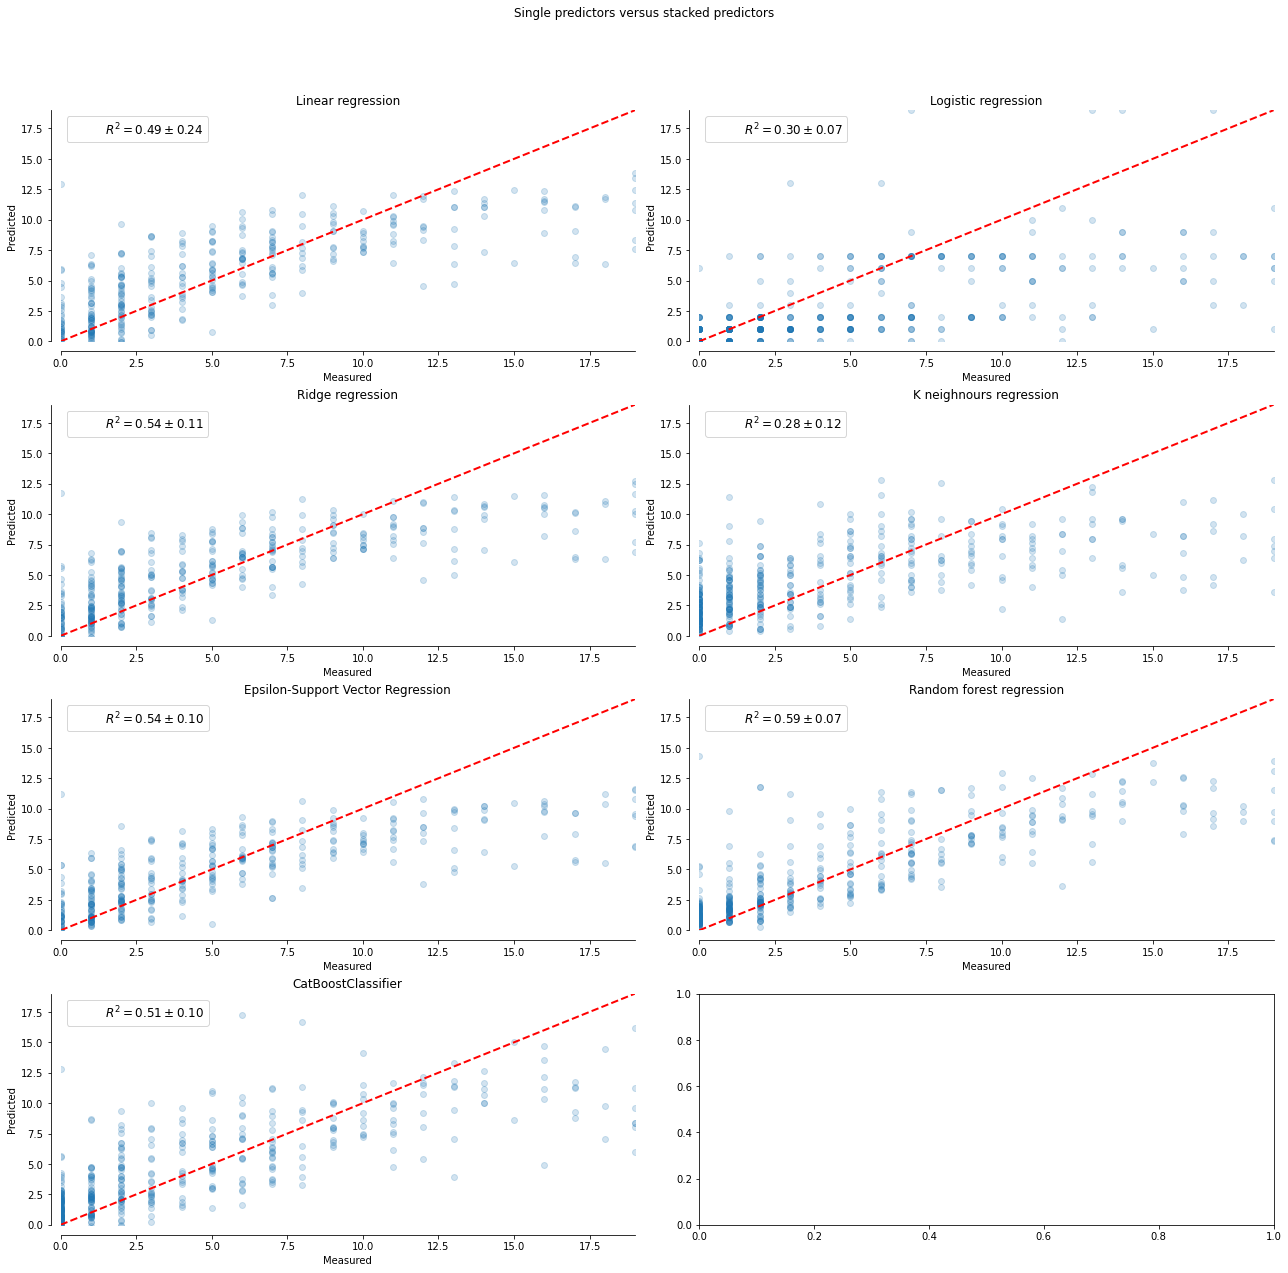

In [24]:
fig, axs = plt.subplots(4, 2, figsize=(18, 18))
axs = np.ravel(axs)
for ax, title, model in zip(axs, titles, best_models):
    score = cross_validate(model, X, y,
                          scoring=['r2'],
                          n_jobs=-1, verbose=0)
    y_pred = cross_val_predict(model, X, y, n_jobs=-1, verbose=0)
    plot_regression_results(
        ax, y, y_pred,
        title,
        (r'$R^2={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2'])))

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Наилучшей моделью оказалась RandomForestRegressor. Она имеет наилучшее качество предсказания R^2 и наименьшее среднеквадратичное отклонение этого параметра.

In [26]:
best = best_models[-2]
print(best)

RandomForestRegressor(max_depth=7, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=50)
